In [1]:
TRAIN = '/kaggle/input/square-vs-rectangle-classification/'

We want to use image embeddings from ResNeXt for EDA and for classification, so let's add some code that will get our image embeddings.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 120MB/s]


Next let's load up all of the data, including embeddings and thumbnails. We only have 1000 images, so we can load all the data in just a couple of minutes.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'])
        for index, input_file in enumerate(list(iglob(pathname=arg))) ]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*')}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 500 rows of square  in 0:01:29.461047
encoded 500 rows of rectangle  in 0:01:25.857919
done in 0:02:55.400715


Next let's use TSNE to get x/y coordinates based on our image embeddings.

In [4]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.007s...
[t-SNE] Computed neighbors for 1000 samples in 0.201s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.123793
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.844078
[t-SNE] KL divergence after 1000 iterations: 1.146076


Now we're ready to plot.

In [5]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']])
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: squares and rectangles', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? We see a lot of local clustering: for any given instance, most of its neighbors are of the same class. But we don't see two distinct clusters, as we might expect given how easy it is for a person to tell a rectangle from a square. We should probably have moderate expectations regarding model accuracy. Let's build a model and see what we get.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.25, random_state=2025, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 295 iterations
accuracy: 0.8400
f1: 0.8396
              precision    recall  f1-score   support

   rectangle       0.88      0.79      0.83       125
      square       0.81      0.89      0.85       125

    accuracy                           0.84       250
   macro avg       0.84      0.84      0.84       250
weighted avg       0.84      0.84      0.84       250



An f1 of 0.84 isn't bad for almost no effort, and it is probably pretty good given what we see in the TSNE plot above. What do our model probabilities look like?

<Axes: xlabel='probability', ylabel='Count'>

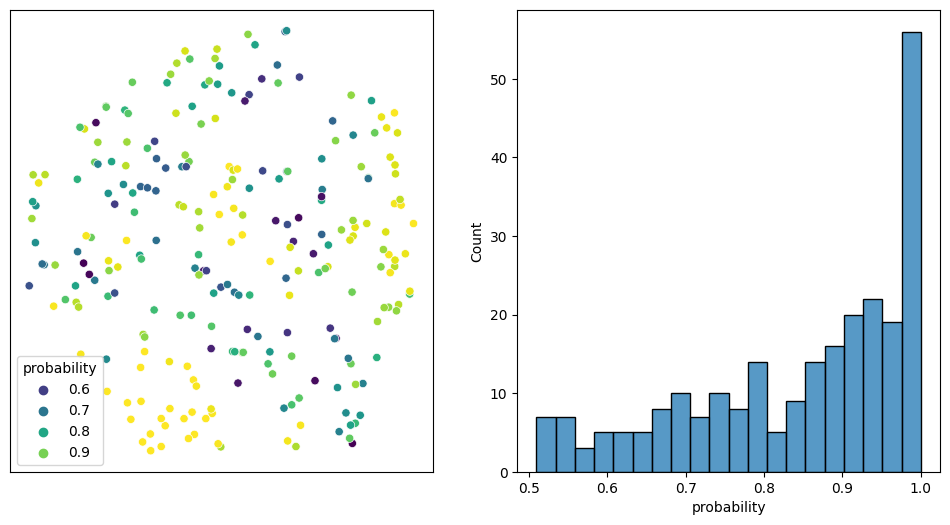

In [7]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')


plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

It is interesting to note that there are instances where our model can't tell a square from a rectangle. 

<Axes: >

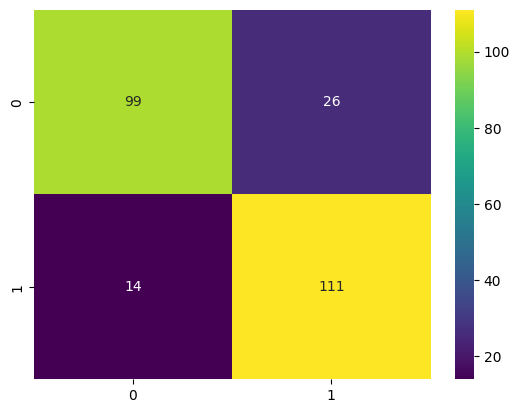

In [8]:
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

heatmap(annot=True, data=pd.DataFrame(data=confusion_matrix(y_true=y_test, y_pred=logreg.predict(X=X_test), ),), cmap='viridis', fmt='2')

Our model mistakes a rectangle for a square about twice as often as it mistakes a square for a rectangle. Go figure.